<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/coffee_better2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np 
from keras.models import Model
from keras.layers import Flatten#,Dense,Dropout,Conv2D
from keras.applications import densenet#mobilenet_v2#,efficientnet,vgg16,densenet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
#from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [21]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [4]:
def k_means_segmentation(img):
  twoDimage = img.reshape((-1,3))
  twoDimage = np.float32(twoDimage)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=1
  ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_imag

def color_mask_segmentation(img):
  hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  light_blue = (90, 70, 50)
  #dark_blue = (128, 255, 255)
  # You can use the following values for green
  light_green = (40, 40, 40)
  # dark_greek = (70, 255, 255)
  mask = cv2.inRange(hsv_img, light_blue, light_green)
  result = cv2.bitwise_and(img, img, mask=mask)
  return result

def filter_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])
  
def otsu_segmentation(img):
    img_gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    thresh = threshold_otsu(img_gray)
    img_otsu  = img_gray < thresh
    filtered = filter_image(img, img_otsu)
    return filtered

In [4]:
SIZE = 224
train_image = []
train_label = []
for dir_path in glob.glob("/content/drive/My Drive/train_cro/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        #img = otsu_segmentation(img)
        train_image.append(img)
        train_label.append(label)
train_image = np.array(train_image)
train_label = np.array(train_label)

val_image = []
val_label = []
for dir_path_v in glob.glob("/content/drive/My Drive/validation_cro/*"):
    label_v = dir_path_v.split("\\")[-1]
    #print(label_v)
    for img_path_v in glob.glob(os.path.join(dir_path_v,"*.jpg")):
        #print(img_path_v)
        img = cv2.imread(img_path_v,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        #img = otsu_segmentation(img)
        val_image.append(img)
        val_label.append(label_v)
val_image = np.array(val_image)
val_label = np.array(val_label)

/content/drive/My Drive/train_cro/rust_cro
/content/drive/My Drive/train_cro/rust_cro/100.jpg
/content/drive/My Drive/train_cro/rust_cro/100_1.jpg
/content/drive/My Drive/train_cro/rust_cro/102.jpg
/content/drive/My Drive/train_cro/rust_cro/102_1.jpg
/content/drive/My Drive/train_cro/rust_cro/103.jpg
/content/drive/My Drive/train_cro/rust_cro/103_1.jpg
/content/drive/My Drive/train_cro/rust_cro/104.jpg
/content/drive/My Drive/train_cro/rust_cro/107.jpg
/content/drive/My Drive/train_cro/rust_cro/107_1.jpg
/content/drive/My Drive/train_cro/rust_cro/108.jpg
/content/drive/My Drive/train_cro/rust_cro/109.jpg
/content/drive/My Drive/train_cro/rust_cro/109_1.jpg
/content/drive/My Drive/train_cro/rust_cro/110.jpg
/content/drive/My Drive/train_cro/rust_cro/110_1.jpg
/content/drive/My Drive/train_cro/rust_cro/111.jpg
/content/drive/My Drive/train_cro/rust_cro/112.jpg
/content/drive/My Drive/train_cro/rust_cro/112_1.jpg
/content/drive/My Drive/train_cro/rust_cro/113.jpg
/content/drive/My Drive/t

In [ ]:
from skimage import io
img = train_image[123]
print(img.shape)
#img = cv2.imread(val_image[0])
io.imshow(img)
plt.show()

In [5]:
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_labe_encoded = le.transform(train_label)
le.fit(val_label)
val_label_encoded = le.transform(val_label)

In [6]:
x_train,y_train,x_test,y_test = train_image,train_labe_encoded,val_image,val_label_encoded

In [7]:
x_train,x_test = x_train/255.0,x_test/255.0

In [8]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [8]:
model = densenet.DenseNet121(weights=None,input_shape=(224,224,3))
#model.summary()

In [9]:
out = Flatten()(model.get_layer(index = -5).output)

In [10]:
e_model = Model(inputs = model.input,outputs = out)

In [14]:
del(model)

In [11]:
print("Feature extraction ...")
prediction = np.array(e_model.predict(x_train))
prediction.shape

Feature extraction ...


(2523, 50176)

In [12]:
Xtrain = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

In [13]:
del(prediction)

In [15]:
prediction = np.array(e_model.predict(x_test))

In [16]:
Xtest = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

In [17]:
del(prediction)

In [18]:
print('\tFeatures training shape: ', Xtrain.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (2523, 50176)
	Features testing shape:  (880, 50176)


In [19]:
print("Classification with Linear SVM ...")
svm = SVC(kernel='linear')
svm.fit(Xtrain, np.ravel(y_train, order='C'))
result = svm.predict(Xtest)

acc = accuracy_score(result, np.ravel(y_test, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)

Classification with Linear SVM ...
	Accuracy Linear SVM: 0.7898


In [20]:
print(confusion_matrix(y_test,result))

[[228   7   0  17]
 [ 17 116   0  39]
 [  0   2 185   5]
 [ 64  34   0 166]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


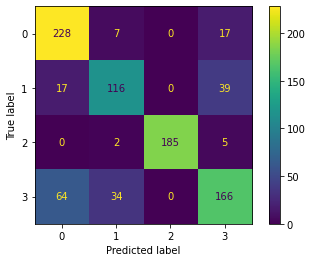

In [23]:
plot_confusion_matrix(svm,Xtest,y_test)
plt.show()

In [19]:
print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       252
           1       0.75      0.72      0.73       172
           2       0.78      0.63      0.70       264

    accuracy                           0.76       688
   macro avg       0.76      0.76      0.75       688
weighted avg       0.76      0.76      0.76       688



In [ ]:
rf = RandomForestClassifier(n_estimators=50,random_state=42)
rf.fit(Xtrain, np.ravel(y_train, order='C'))

In [34]:
result_rf = rf.predict(Xtest)

In [35]:
acc = accuracy_score(result_rf, np.ravel(y_test, order='C'))
print("\tAccuracy Linear SVM: %0.4f" % acc)
print(confusion_matrix(y_test,result))
print(classification_report(y_test,result))

	Accuracy Linear SVM: 0.7386
[[228   7   0  17]
 [ 17 116   0  39]
 [  0   2 185   5]
 [ 64  34   0 166]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       252
           1       0.73      0.67      0.70       172
           2       1.00      0.96      0.98       192
           3       0.73      0.63      0.68       264

    accuracy                           0.79       880
   macro avg       0.80      0.79      0.79       880
weighted avg       0.79      0.79      0.79       880



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


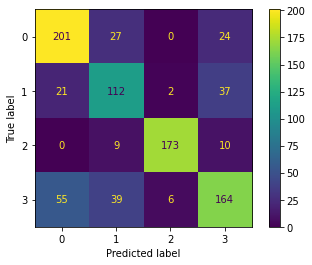

In [36]:
plot_confusion_matrix(rf,Xtest,y_test)
plt.show()